# Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Import dataSet

In [2]:
df = pd.read_csv("path")

# Initial view of data

In [3]:
print("First few records:\n", df.head())
print("\nData Info:")
df.info()
print("\nStatistical Summary:\n", df.describe())

First few records:
   Patient ID  Age     Sex  Cholesterol Blood Pressure  Heart Rate  Diabetes  \
0    BMW7812   67    Male          208         158/88          72         0   
1    CZE1114   21    Male          389         165/93          98         1   
2    BNI9906   21  Female          324         174/99          72         1   
3    JLN3497   84    Male          383        163/100          73         1   
4    GFO8847   66    Male          318          91/88          93         1   

   Family History  Smoking  Obesity  ...  Sedentary Hours Per Day  Income  \
0               0        1        0  ...                 6.615001  261404   
1               1        1        1  ...                 4.963459  285768   
2               0        0        0  ...                 9.463426  235282   
3               1        1        0  ...                 7.648981  125640   
4               1        1        1  ...                 1.514821  160555   

         BMI  Triglycerides  Physical Acti

# preprocessing

## Check Null

In [4]:
print(df.isnull().sum())

Patient ID                         0
Age                                0
Sex                                0
Cholesterol                        0
Blood Pressure                     0
Heart Rate                         0
Diabetes                           0
Family History                     0
Smoking                            0
Obesity                            0
Alcohol Consumption                0
Exercise Hours Per Week            0
Diet                               0
Previous Heart Problems            0
Medication Use                     0
Stress Level                       0
Sedentary Hours Per Day            0
Income                             0
BMI                                0
Triglycerides                      0
Physical Activity Days Per Week    0
Sleep Hours Per Day                0
Country                            0
Continent                          0
Hemisphere                         0
Heart Attack Risk                  0
dtype: int64


## Identification and processing of outliers

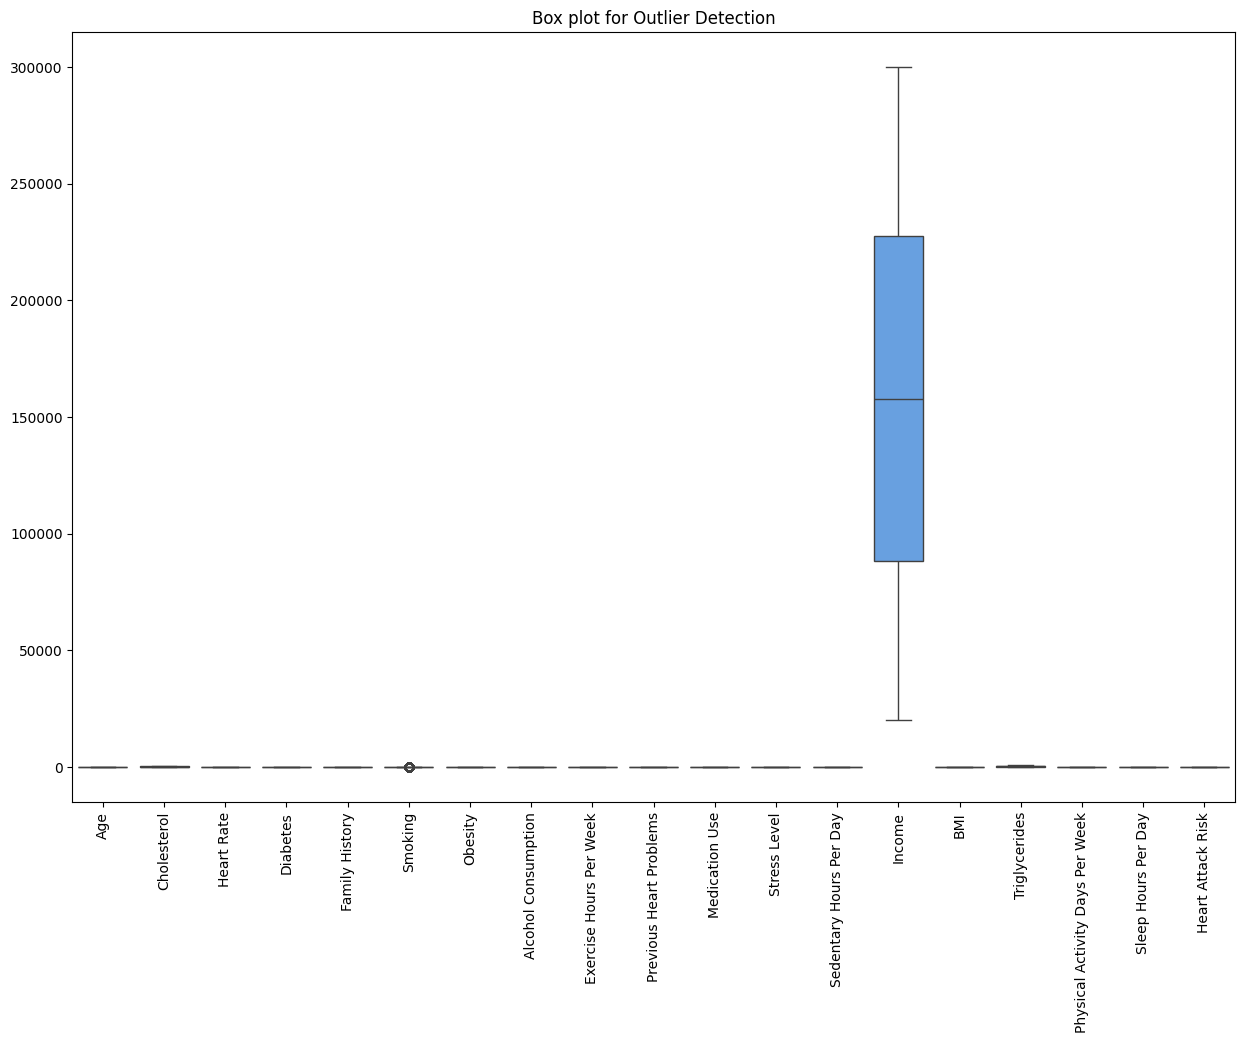

In [5]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df)
plt.title("Box plot for Outlier Detection")
plt.xticks(rotation=90)
plt.show()

## Drop Patient ID

In [6]:
df = df.drop('Patient ID' , axis=1)

## Coding nominal data

In [7]:
label_encoders = {}
for column in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Feature distribution analysis

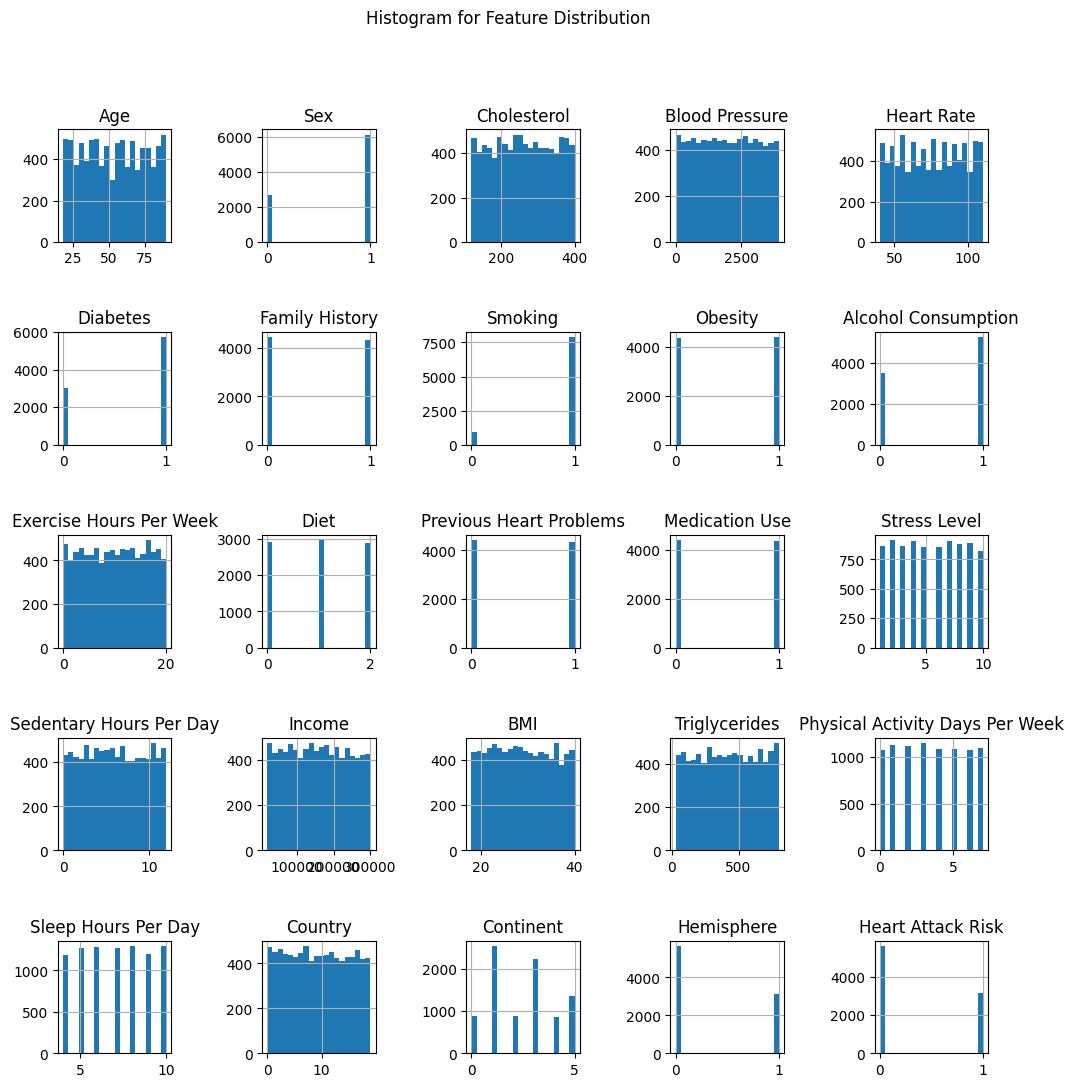

In [8]:
df.hist(figsize=(12, 12), bins=20)
plt.suptitle("Histogram for Feature Distribution")
plt.subplots_adjust(hspace=0.8 , wspace=0.8)
plt.show()

# Split data into attributes and tags

In [9]:
target_column = 'Heart Attack Risk'
root_feature = 'Sex'

In [10]:
columns_order = [root_feature] + [col for col in df.columns if col not in [target_column, root_feature]]
X = df[columns_order]
y = df[target_column]

## Dividing data into training and test sets

In [46]:
y.value_counts(normalize=True)*100


Heart Attack Risk
0    64.178934
1    35.821066
Name: proportion, dtype: float64

In [49]:
from imblearn.over_sampling import SMOTE
smote=SMOTE(random_state=365)
x_smote,y_smote=smote.fit_resample(X,y)

y_smote.value_counts(normalize=True)


Heart Attack Risk
0    0.5
1    0.5
Name: proportion, dtype: float64

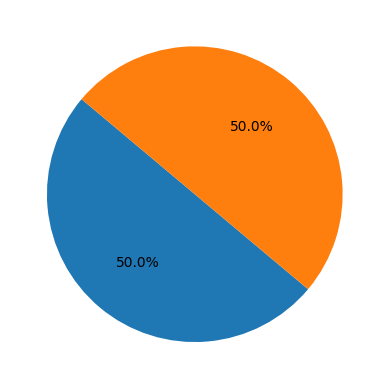

In [50]:
plt.pie(y_smote.value_counts(), autopct="%1.1f%%", startangle=140)
plt.show()


In [52]:
X_train,X_test,y_train,y_test=train_test_split(x_smote,y_smote, test_size=0.2)


## Data standardization

In [58]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [59]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [60]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)

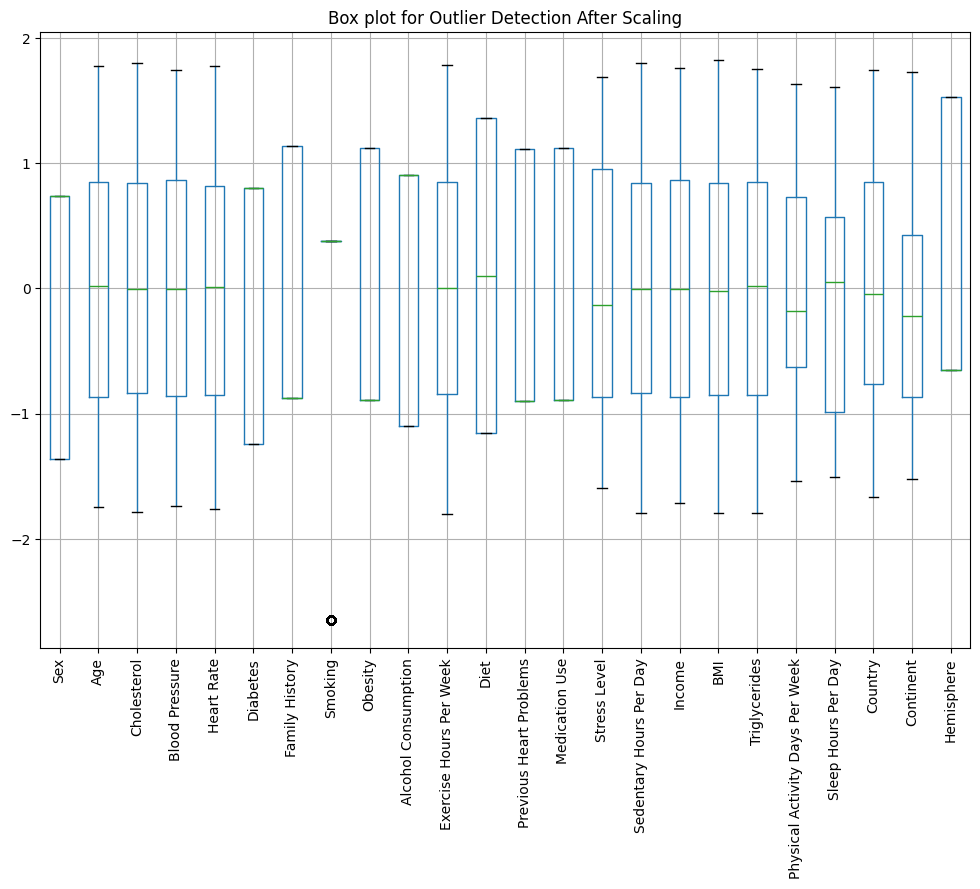

In [61]:
plt.figure(figsize=(12, 8))
X_train_scaled_df.boxplot()
plt.xticks(rotation=90)
plt.title("Box plot for Outlier Detection After Scaling")
plt.show()

# Creation and training of Ensemble method

In [62]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
svm = SVC(kernel='rbf', probability=True, C=1.0)

ensemble_model = VotingClassifier(estimators=[
    ('Random Forest', rf),
    ('Gradient Boosting', gb),
    ('SVM', svm)
], voting='soft', weights=[2, 2, 1]) 

ensemble_model.fit(X_train, y_train)

VotingClassifier(estimators=[('Random Forest',
                              RandomForestClassifier(random_state=42)),
                             ('Gradient Boosting',
                              GradientBoostingClassifier(random_state=42)),
                             ('SVM', SVC(probability=True))],
                 voting='soft', weights=[2, 2, 1])

# Model prediction and evaluation

In [63]:
y_pred = ensemble_model.predict(X_test)

# Calculation of model accuracy and size metrics

In [71]:
print("Accuracy: {:.8f}".format(accuracy_score(y_test, y_pred)))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.66400000
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.77      0.69      1090
           1       0.72      0.57      0.64      1160

    accuracy                           0.66      2250
   macro avg       0.67      0.67      0.66      2250
weighted avg       0.67      0.66      0.66      2250

Confusion Matrix:
 [[836 254]
 [502 658]]


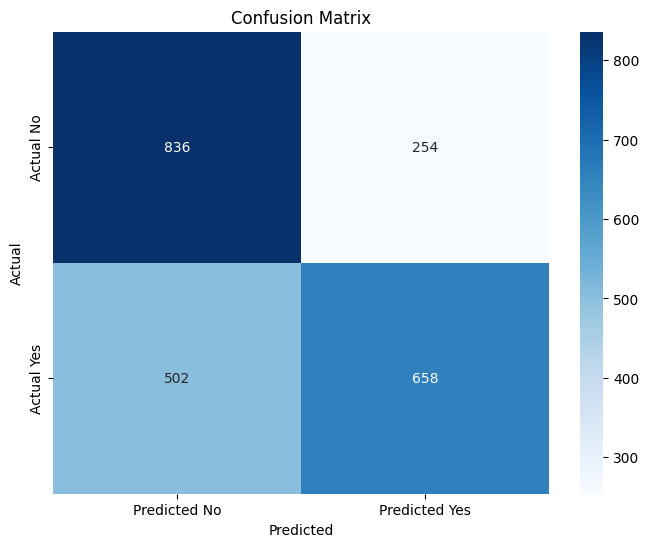

In [72]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()